# Prepare data


In [56]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import zipfile
import os

zip_file_path = './iris.zip'
extracted_path = './iris_data'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

iris_file_path = os.path.join(extracted_path, 'iris.data')
columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris_data = pd.read_csv(iris_file_path, header=None, names=columns)

for index, row in iris_data.iterrows():
  if row['class'] == 'Iris-setosa':
    iris_data.at[index, 'class'] = 0
  elif row['class'] == 'Iris-versicolor':
    iris_data.at[index, 'class'] = 1
  elif row['class'] == 'Iris-virginica':
    iris_data.at[index, 'class'] = 2

iris_data.head()
features = iris_data.iloc[:, :-1].values
scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(features)

# SOM training loop

In [4]:
def get_neighboor_hierarchy(wx1,wy1,x2,y2):
    distX = wx1 - x2 if wx1 > x2 else x2 - wx1
    distY = wy1 - y2 if wy1 > y2 else y2 - wy1
    return distX if distX > distY else distY

def SOM_training(data, neurons, epochs, row_num, col_num):
    for epoch in range(epochs):
      for entry in data:
        distances = np.zeros((row_num, col_num))
        for row in range(row_num):
          for col in range(col_num):
            distances[row,col] = np.sqrt(np.sum((neurons[row,col] - entry) ** 2))

        neuron_winner = np.unravel_index(np.argmin(distances), distances.shape)

        for row in range(row_num):
          for col in range(col_num):
            distWin = np.sqrt((row - neuron_winner[0]) ** 2 + (col - neuron_winner[1]) ** 2)
            hier = get_neighboor_hierarchy(neuron_winner[0], neuron_winner[1], row, col)
            if hier != 0:
              gausH = (1 - epoch/epochs) * np.exp(-distWin ** 2 / (2 * get_neighboor_hierarchy(neuron_winner[0], neuron_winner[1], row, col) ** 2))
              neurons[row, col] = neurons[row, col] + gausH * (entry - neurons[row, col])

    return neurons

# Evaluations and visualizations

In [5]:
def quantization_error(data, som):
    error = 0
    for entry in data:
        distances = np.zeros((som.shape[0], som.shape[1]))
        for row in range(som.shape[0]):
            for col in range(som.shape[1]):
                distances[row, col] = np.sqrt(np.sum((som[row,col] - entry) ** 2))

        neuron_winner = np.unravel_index(np.argmin(distances), distances.shape)
        error += np.sqrt(np.sum((som[row,col] - entry) ** 2))
    return error / len(data)

In [51]:
def plot_som_with_pies(som, clusters, title="SOM with Pies in Grid"):
    plt.figure(figsize=(8, 8))
    plt.title(title)

    # SOM grid dimensions
    row_num, col_num, _ = som.shape

    # Colors for classes
    colors = ['red', 'green', 'blue']

    for row in range(row_num):
        for col in range(col_num):
            # Get class proportions for this node
            class_counts = clusters.get((row, col), {0: 0, 1: 0, 2: 0})
            total = sum(class_counts.values())

            if total > 0:
                # Proportions for the pie chart
                sizes = [class_counts[cls] / total for cls in sorted(class_counts.keys())]

                # Draw the pie chart at the center of the grid cell
                pie = plt.pie(
                    sizes,
                    colors=colors,
                    radius=0.3,  # Control pie chart size
                    center=(col+0.5, row+0.5),
                    wedgeprops={"edgecolor": "black", "linewidth": 0.5},
                )
            else:
               plt.scatter(col+0.5, row+0.5, s=400, marker='o', c='lightgrey', edgecolors='black')
    plt.gca().invert_yaxis()
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    plt.xticks(range(0, col_num+1), labels=range(0, col_num+1))
    plt.yticks(range(0, row_num+1), labels=range(0, row_num+1))
    plt.xlabel("SOM Columns")
    plt.ylabel("SOM Rows")
    plt.show()


In [52]:
def assign_clusters_with_classes(data, som, labels):
    clusters = {}
    row_num, col_num, _ = som.shape
    for idx, entry in enumerate(data):
        distances = np.zeros((row_num, col_num))
        for row in range(row_num):
            for col in range(col_num):
                distances[row, col] = np.sqrt(np.sum((som[row, col] - entry) ** 2))
        neuron_winner = np.unravel_index(np.argmin(distances), distances.shape)
        if neuron_winner not in clusters:
            clusters[neuron_winner] = {0: 0, 1: 0, 2: 0}  # Initialize with class counts
        clusters[neuron_winner][labels[idx]] += 1  # Increment the class count
    return clusters

# Execution

SOM 5x5 quantization error: 0.5808103303578169
SOM 10x10 quantization error: 0.5871646892146392


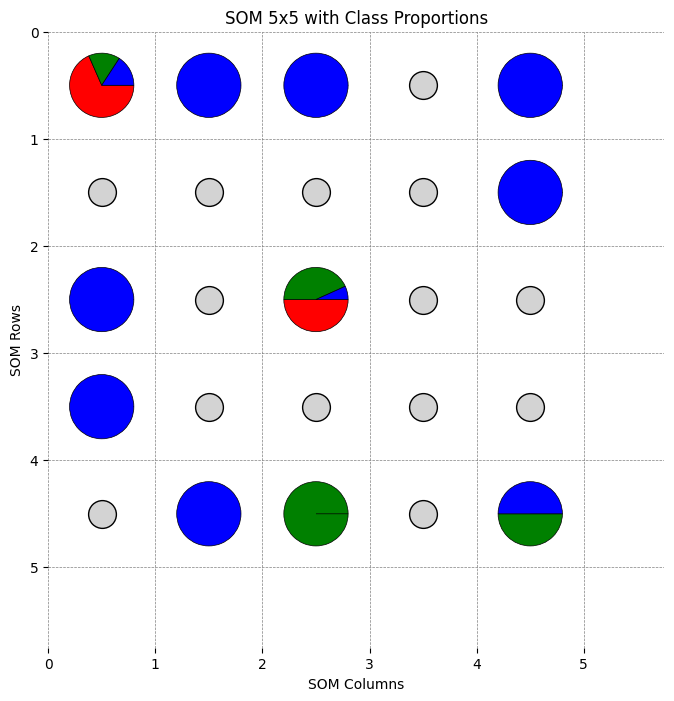

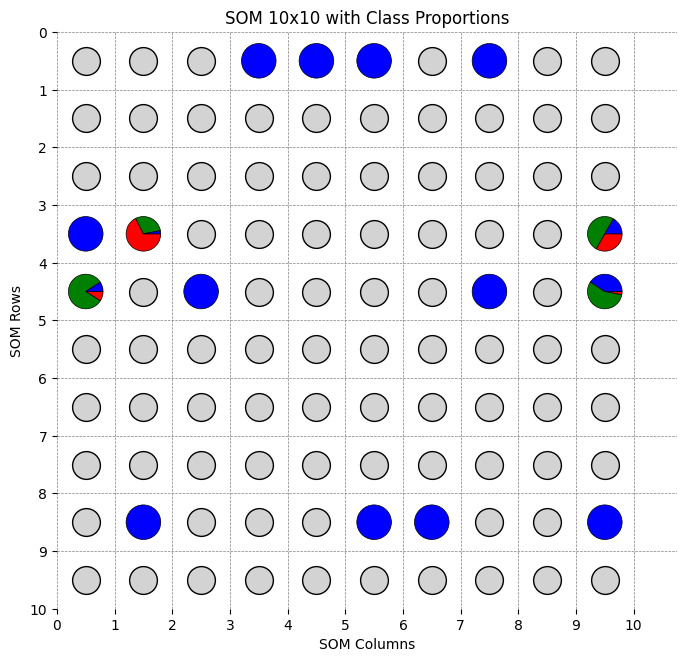

In [57]:
som_5x5 = SOM_training(features, np.random.rand(5, 5, 4), 10, 5, 5)
som_10x10 = SOM_training(features, np.random.rand(10, 10, 4), 10, 10, 10)

print(f'SOM 5x5 quantization error: {quantization_error(features, som_5x5)}')
print(f'SOM 10x10 quantization error: {quantization_error(features, som_10x10)}')

labels = iris_data['class'].astype(int).values
clusters_5x5 = assign_clusters_with_classes(features, som_5x5, labels)
clusters_10x10 = assign_clusters_with_classes(features, som_10x10, labels)
plot_som_with_pies(som_5x5, clusters_5x5, title="SOM 5x5 with Class Proportions")
plot_som_with_pies(som_10x10, clusters_10x10, title="SOM 10x10 with Class Proportions")


SOM 5x5 quantization error: 0.47696675925790205
SOM 10x10 quantization error: 0.477425016065707


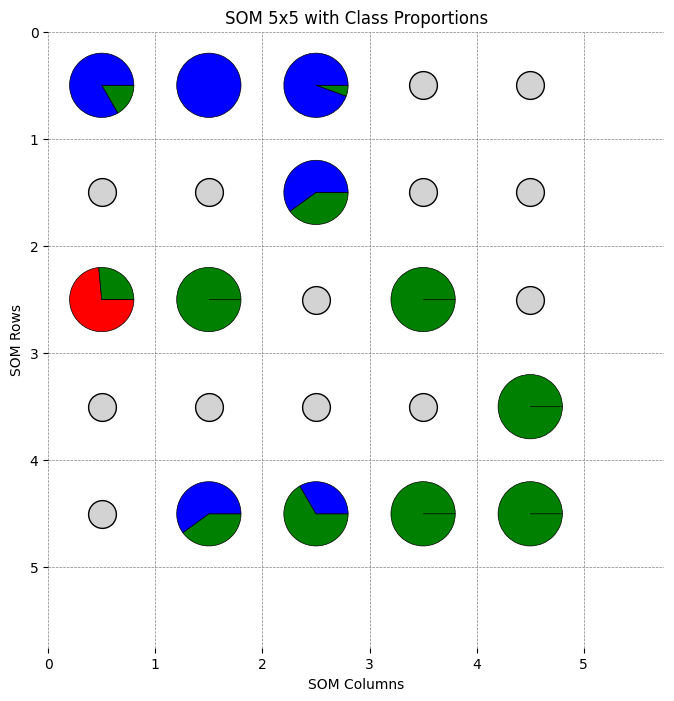

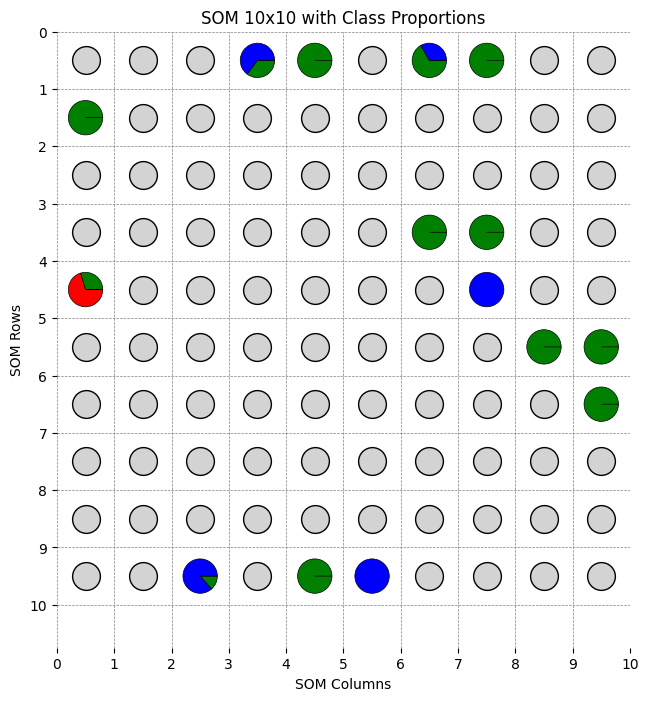

In [58]:
som_5x5 = SOM_training(features, np.random.rand(5, 5, 4), 100, 5, 5)
som_10x10 = SOM_training(features, np.random.rand(10, 10, 4), 100, 10, 10)

print(f'SOM 5x5 quantization error: {quantization_error(features, som_5x5)}')
print(f'SOM 10x10 quantization error: {quantization_error(features, som_10x10)}')

labels = iris_data['class'].astype(int).values
clusters_5x5 = assign_clusters_with_classes(features, som_5x5, labels)
clusters_10x10 = assign_clusters_with_classes(features, som_10x10, labels)
plot_som_with_pies(som_5x5, clusters_5x5, title="SOM 5x5 with Class Proportions")
plot_som_with_pies(som_10x10, clusters_10x10, title="SOM 10x10 with Class Proportions")


SOM 5x5 quantization error: 0.47902741571177965
SOM 10x10 quantization error: 0.479063011139522


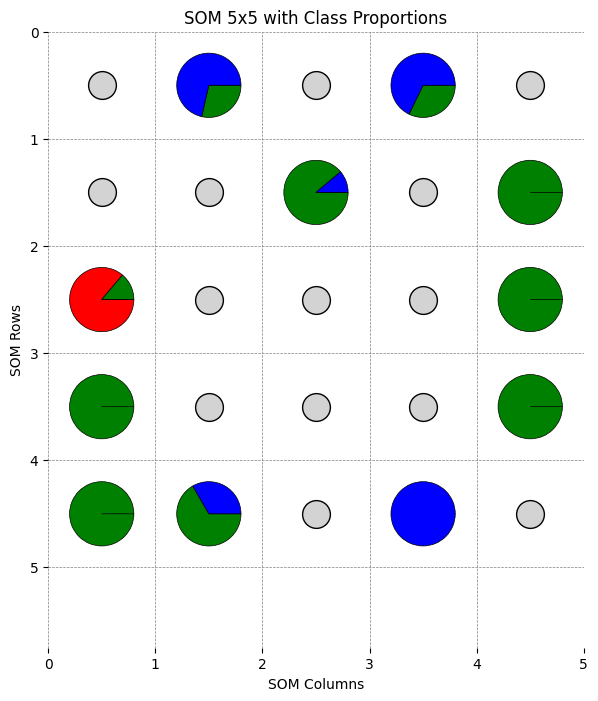

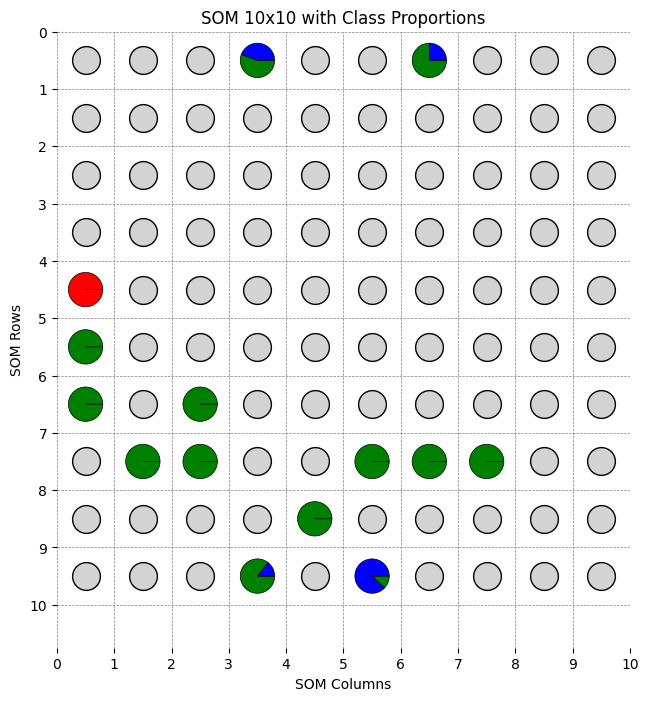

In [59]:
som_5x5 = SOM_training(features, np.random.rand(5, 5, 4), 1000, 5, 5)
som_10x10 = SOM_training(features, np.random.rand(10, 10, 4), 1000, 10, 10)

print(f'SOM 5x5 quantization error: {quantization_error(features, som_5x5)}')
print(f'SOM 10x10 quantization error: {quantization_error(features, som_10x10)}')

labels = iris_data['class'].astype(int).values
clusters_5x5 = assign_clusters_with_classes(features, som_5x5, labels)
clusters_10x10 = assign_clusters_with_classes(features, som_10x10, labels)
plot_som_with_pies(som_5x5, clusters_5x5, title="SOM 5x5 with Class Proportions")
plot_som_with_pies(som_10x10, clusters_10x10, title="SOM 10x10 with Class Proportions")
